# Initalize libraries

## Import libraries

In [290]:
import sys, os
import time
from os.path import join
from os import path
from importlib import reload
from getpass import getuser
from glob import glob
from tqdm.auto import tqdm

# Data
import xarray as xr
import h5py
import numpy as np
from nexusformat.nexus import *

# Plotting
import imageio
import matplotlib.pyplot as plt
import fabio

# skimage
import skimage.morphology

# scipy
from scipy.ndimage.filters import gaussian_filter
import scipy
from scipy import stats

# pyFAI
import pyFAI
from pyFAI.azimuthalIntegrator import AzimuthalIntegrator
from pyFAI.detectors import Detector

# Self-written libraries
sys.path.append(join(os.getcwd(), "library"))
import PETRA_MaxP04_loading as loading
import reconstruct as reco
import fthcore as fth
import helper_functions as helper
import interactive
from interactive import cimshow
import reconstruct_rb as rec
import reconstruct as reco
import mask_lib

plt.rcParams["figure.constrained_layout.use"] = True  # replaces plt.tight_layout

/tmp/ipykernel_5389/2129642630.py:25: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


In [291]:
# Is there a GPU?
try:
    # Cupy
    import cupy as cp
    import cupyx as cpx

    GPU = True

    print("GPU available")

    # Self-written library
    import CCI_core_cupy as cci
    import Phase_Retrieval as PhR
except:
    GPU = False
    import CCI_core as cci

    print("GPU unavailable")

GPU available


In [292]:
# interactive plotting
import ipywidgets

%matplotlib widget

# Auto formatting of cells
#%load_ext jupyter_black

## Experiment specific Functions

In [293]:
PROPOSAL = 11013284
USER = getuser()

### Loading data

In [379]:
BASEFOLDER = "/data/beamtimes/PETRA/2204_MAXI_MaxP04/%s/" % PROPOSAL
subfolder = "MAX_P04"
sample_name = "maxp04_"
raw_folder = join(BASEFOLDER, "raw", subfolder)

# Load mnemonics for easy data handling
mnemonics = loading.mnemonics

# Full image loading procedure
def load_processing(im_id, crop=None):
    """
    Loads images, averaging of two individual images (scans in tango consist of two images),
    padding to square shape, Additional cropping (optional)
    
    Parameter
    =========
    im_id : int 
        image data identifier number
    crop : int
        crops image arrays according to array[:crop, :crop]
        
    Output
    ======
    files : list
        list of searched filenames
    ======
    author: ck 2024
    """
    # Generate file name
    fname = loading.generate_filename(raw_folder, sample_name, ".nxs", im_id)

    # Load data
    images = loading.load_images(fname)

    # Zeropad to get square shape
    images = helper.padding(images)

    # Optional cropping
    if crop is not None:
        images = images[..., :crop, :crop]
    
    # Calculate mean
    if images.ndim > 2:
        image = np.mean(images, axis=0)
    else:
        image = images.copy()

    return image, images

### Loading, saving fth & cdi data

In [295]:
# Saving of log files for fth and cdi recos
def save_fth_h5():
    # Save h5
    data = {}
    data["im_id"] = im_id
    data["topo_id"] = topo_id
    data["topo_centered"] = topo_c
    data["im_centered"] = im_c
    data["sum_b"] = sum_b
    data["recon"] = recon
    data["factor"] = factor
    data["offset"] = offset
    data["center"] = center
    data["roi"] = roi
    data["prop_dist"] = prop_dist
    data["phase"] = phase
    data["mask_bs"] = mask_bs
    data["bs_diam"] = bs_diam

    filename = join(
        folder_general, "Logs", "Data_ImId_%04d_RefId_%s_%s" % (im_id, topo_id, USER)
    )
    print("Now Saving: %s" % filename)
    cci.create_hdf5(data, filename)


def save_cdi_h5():
    # Save h5
    data = {}
    data["im_id"] = im_id
    data["topo_id"] = topo_id
    data["pos"] = pos
    data["neg"] = neg
    data["factor"] = factor
    data["offset"] = offset
    data["center"] = center
    data["roi"] = roi
    data["prop_dist"] = prop_dist_cdi
    data["phase"] = phase_cdi
    data["mask_bs"] = mask_bs
    data["bs_diam"] = bs_diam_cdi
    data["supportmask"] = supportmask
    data["mask_pixel"] = mask_pixel
    data["p_pc"] = p_pc
    data["n_pc"] = n_pc

    filename = join(
        folder_general,
        "Logs",
        "Data_ImId_%04d_RefId_%s_cdi_%s" % (im_id, topo_id, USER),
    )
    print("Now Saving: %s" % filename)
    cci.create_hdf5(data, filename)
    return


def save_topo_holo(topo_c, pos_id, neg_id):
    """
    Save only topo holos which can be later used for single helicity reconstructions
    """
    data = {}
    data["pos_id"] = pos_id
    data["neg_id"] = neg_id
    data["topo"] = topo_c

    filename = join(
        folder_general,
        "Topos",
        "Topo_ImId_%04d_RefId_%04d_cdi_%s" % (pos_id, neg_id, USER),
    )
    print("Now Saving: %s" % filename)
    cci.create_hdf5(data, filename)
    return


def load_topo_holo(pos_id, neg_id):
    """
    Load topo holos for single helicity reconstructions
    """
    fname = join(
        folder_general,
        "Topos",
        "Topo_ImId_%04d_RefId_%04d_cdi_%s.hdf5" % (pos_id, neg_id, USER),
    )

    with h5py.File(fname, "r") as f:
        im_out = f["topo"][()]
    return im_out


def load_fth(im_id, topo_id):
    """
    Load fth dataset
    """
    fname = join(
        folder_target,
        "Logs",
        "Data_ImId_%s_RefId_%s_%s.hdf5"
        % (
            im_id,
            topo_id,
            USER,
        ),
    )

    with h5py.File(fname, "r") as f:
        data = {}
        for key in f.keys():
            if key != "experimental_setup":
                data[key] = f[key][()]

    return data

def load_cdi(im_id, topo_id):
    """
    Load cdi dataset
    """
    fname = join(
        folder_target,
        "Logs",
        "Data_ImId_%s_RefId_%s_cdi_%s.hdf5" % (im_id, topo_id, USER),
    )

    with h5py.File(fname, "r") as f:
        data = {}
        for key in f.keys():
            if key != "experimental_setup":
                data[key] = f[key][()]

    return data_cdi

### Other

In [296]:
# Setup phase and propagation for cdi once
phase_cdi = 0
prop_dist_cdi = 0
dx = 0
dy = 0


def phase_retrieval(
    pos, neg, mask_pixel, supportmask, Startimage=None, Startgamma=None
):
    # Prepare Input holograms
    pos2 = pos.copy()
    neg2 = neg.copy()

    mi, _ = np.percentile(pos2[pos2 != 0], [1, 99.9])
    pos2 = pos2 - mi
    mi, _ = np.percentile(neg2[neg2 != 0], [1, 99.9])
    neg2 = neg2 - mi

    pos2[pos2 < 0] = 0
    neg2[neg2 < 0] = 0
    pos2 = pos2.astype(complex)
    neg2 = neg2.astype(complex)

    bsmask_p = mask_pixel.copy()
    bsmask_p[pos2 <= 2] = 1
    bsmask_n = mask_pixel.copy()
    bsmask_n[neg2 <= 2] = 1

    # Setup start image and startgamma
    if Startimage is None:
        Startimage = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(supportmask)))
    else:
        Startimage = Startimage.copy()
    if Startgamma is None:
        Startgamma = np.ones(pos.shape) * 1e-6 * 2
        Startgamma[pos.shape[0] // 2, pos.shape[1] // 2] = 0.7
    else:
        Startgamma = Startgamma.copy()

    # Settings for phase retrieval reconstructions
    partial_coherence = True

    # Setup
    retrieved_p = np.zeros(pos2.shape, np.cdouble)
    retrieved_n = np.zeros(pos2.shape, np.cdouble)

    # Algorithms and Inital guess
    plt.rcParams["figure.dpi"] = 100
    print("CDI - larger mask")

    algorithm_list = ["mine", "mine", "mine"]
    Nit_list = [700, 50, 50]  # iterations for algorithm_list

    x = (np.sqrt(np.maximum(pos2, np.zeros(pos2.shape)))[mask_pixel == 0]).flatten()
    y = ((np.abs(Startimage))[mask_pixel == 0]).flatten()
    res = stats.linregress(x, y)
    Startimage -= res.intercept
    Startimage /= res.slope

    average_img = 30
    real_object = False  # always set to False

    if partial_coherence:
        RL_freq = 20
        RL_it = 50

        algorithm_list_pc = ["mine", "ER", "ER"]
        Nit_list_pc = [700, 50, 50]

    # Execute Phase retrieval
    start_time = time.time()
    for i in range(len(Nit_list) // 3):
        print("############ -   CDI")

        # Positive helicity - beta_mode="arctan"
        retrieved_p, Error_diff_p, Error_supp = PhR.PhaseRtrv_GPU(
            diffract=np.sqrt(np.maximum(pos2, np.zeros(pos2.shape))),
            mask=supportmask,
            mode=algorithm_list[3 * i],
            beta_zero=0.5,
            Nit=Nit_list[3 * i],
            beta_mode="arctan",
            plot_every=349,
            Phase=Startimage,
            seed=False,
            real_object=real_object,
            bsmask=bsmask_p,
            average_img=average_img,
            Fourier_last=True,
        )

        # Positive helicity - beta_mode="const"
        retrieved_p, Error_diff_p2, Error_supp = PhR.PhaseRtrv_GPU(
            diffract=np.sqrt(np.maximum(pos2, np.zeros(pos2.shape))),
            mask=supportmask,
            mode=algorithm_list[3 * i + 1],
            beta_zero=0.5,
            Nit=Nit_list[3 * i + 1],
            beta_mode="const",
            plot_every=24,
            Phase=retrieved_p,
            seed=False,
            real_object=real_object,
            bsmask=bsmask_p,
            average_img=average_img,
            Fourier_last=True,
        )

        # Negative helicity - beta_mode="arctan"
        retrieved_n, Error_diff_n2, Error_supp = PhR.PhaseRtrv_GPU(
            diffract=np.sqrt(np.maximum(neg2, np.zeros(neg2.shape))),
            mask=supportmask,
            mode=algorithm_list[3 * i + 2],
            beta_zero=0.5,
            Nit=Nit_list[3 * i + 2],
            beta_mode="const",
            plot_every=24,
            Phase=retrieved_p * np.sqrt(np.sum(neg2) / np.sum(pos2)),
            seed=False,
            real_object=real_object,
            bsmask=bsmask_n,
            average_img=average_img,
            Fourier_last=True,
        )

        print("--- %s seconds ---" % np.round((time.time() - start_time), 2))

        Startimage = retrieved_p.copy()

        # Partial coherence phase retrieval
        if partial_coherence:
            # CDI_PC
            print("############   -   CDI_pc")
            pos3 = (np.abs(retrieved_p) ** 2) * bsmask_p + np.maximum(
                pos2, np.zeros(pos2.shape)
            ) * (1 - bsmask_p)
            neg3 = (np.abs(retrieved_n) ** 2) * bsmask_n + np.maximum(
                neg2, np.zeros(neg2.shape)
            ) * (1 - bsmask_n)

            # retrieve pos image
            (
                retrieved_p_pc,
                Error_diff_p_pc,
                Error_supp,
                gamma_p,
            ) = PhR.PhaseRtrv_with_RL(
                diffract=np.sqrt(pos3),
                mask=supportmask,
                mode=algorithm_list_pc[3 * i],
                beta_zero=0.5,
                Nit=Nit_list_pc[3 * i],
                beta_mode="arctan",
                gamma=Startgamma,
                RL_freq=RL_freq,
                RL_it=RL_it,
                plot_every=349,
                Phase=Startimage,
                seed=False,
                real_object=False,
                bsmask=np.zeros(bsmask_p.shape),
                average_img=average_img,
                Fourier_last=True,
            )

            (
                retrieved_p_pc,
                Error_diff_p_pc2,
                Error_supp,
                gamma_p,
            ) = PhR.PhaseRtrv_with_RL(
                diffract=np.sqrt(pos3),
                mask=supportmask,
                mode=algorithm_list[3 * i + 1],
                beta_zero=0.5,
                Nit=Nit_list_pc[3 * i + 1],
                beta_mode="const",
                gamma=gamma_p,
                RL_freq=RL_freq,
                RL_it=RL_it,
                plot_every=24,
                Phase=retrieved_p_pc,
                real_object=False,
                bsmask=np.zeros(bsmask_p.shape),
                average_img=average_img,
                Fourier_last=True,
            )
            (
                retrieved_n_pc,
                Error_diff_n_pc2,
                Error_supp,
                gamma_n,
            ) = PhR.PhaseRtrv_with_RL(
                diffract=np.sqrt(neg3),
                mask=supportmask,
                mode=algorithm_list[3 * i + 2],
                beta_zero=0.5,
                Nit=Nit_list_pc[3 * i + 2],
                beta_mode="const",
                gamma=gamma_p,
                RL_freq=RL_freq,
                RL_it=RL_it,
                plot_every=24,
                Phase=retrieved_p_pc * np.sqrt(np.sum(neg2) / np.sum(pos2)),
                real_object=False,
                bsmask=np.zeros(bsmask_n.shape),
                average_img=average_img,
                Fourier_last=True,
            )

            print("--- %s seconds ---" % np.round((time.time() - start_time), 2))

            Startimage = retrieved_p_pc.copy()
            Startgamma = gamma_p.copy()

    print("Phase Retrieval Done!")

    return (
        retrieved_p,
        retrieved_n,
        retrieved_p_pc,
        retrieved_n_pc,
        bsmask_p,
        bsmask_n,
        gamma_p,
        gamma_n,
    )

In [297]:
# Setup phase and propagation for cdi once = np.array([1, 2, 3])

# np.broadcast_to(x, (3, 3))
phase_cdi = 0
prop_dist_cdi = 0
dx = 0
dy = 0


def phase_retrieval(
    pos, neg, mask_pixel, supportmask, vmin=0, Startimage=None, Startgamma=None
):
    # Prepare Input holograms
    pos2 = pos.copy()
    neg2 = neg.copy()

    mi, _ = np.percentile(pos2[pos2 != 0], [vmin, 99.9])
    pos2 = pos2 - mi
    mi, _ = np.percentile(neg2[neg2 != 0], [vmin, 99.9])
    neg2 = neg2 - mi

    pos2[pos2 < 0] = 0
    neg2[neg2 < 0] = 0
    pos2 = pos2.astype(complex)
    neg2 = neg2.astype(complex)

    bsmask_p = mask_pixel.copy()
    bsmask_p[pos2 <= 0] = 1
    bsmask_n = mask_pixel.copy()
    bsmask_n[neg2 <= 0] = 1

    # Setup start image and startgamma
    if Startimage is None:
        Startimage = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(supportmask)))
    else:
        Startimage = Startimage.copy()
    if Startgamma is None:
        Startgamma = np.ones(pos.shape) * 1e-6 * 2
        Startgamma[pos.shape[0] // 2, pos.shape[1] // 2] = 0.7
    else:
        Startgamma = Startgamma.copy()

    # Settings for phase retrieval reconstructions
    partial_coherence = True

    # Setup
    retrieved_p = np.zeros(pos2.shape, np.cdouble)
    retrieved_n = np.zeros(pos2.shape, np.cdouble)

    # Algorithms and Inital guess
    plt.rcParams["figure.dpi"] = 100
    print("CDI - larger mask")

    algorithm_list = ["mine", "mine", "mine"]
    Nit_list = [700, 50, 50]  # iterations for algorithm_list

    x = (np.sqrt(np.maximum(pos2, np.zeros(pos2.shape)))[mask_pixel == 0]).flatten()
    y = ((np.abs(Startimage))[mask_pixel == 0]).flatten()
    res = stats.linregress(x, y)
    Startimage -= res.intercept
    Startimage /= res.slope

    average_img = 30
    real_object = False  # always set to False

    if partial_coherence:
        RL_freq = 20
        RL_it = 50

        algorithm_list_pc = ["mine", "ER", "ER"]
        Nit_list_pc = [700, 50, 50]

    # Execute Phase retrieval
    start_time = time.time()
    for i in range(len(Nit_list) // 3):
        print("############ -   CDI")

        # Positive helicity - beta_mode="arctan"
        retrieved_p, Error_diff_p, Error_supp = PhR.PhaseRtrv_GPU(
            diffract=np.sqrt(np.maximum(pos2, np.zeros(pos2.shape))),
            mask=supportmask,
            mode=algorithm_list[3 * i],
            beta_zero=0.5,
            Nit=Nit_list[3 * i],
            beta_mode="arctan",
            plot_every=349,
            Phase=Startimage,
            seed=False,
            real_object=real_object,
            bsmask=bsmask_p,
            average_img=average_img,
            Fourier_last=True,
        )

        # Positive helicity - beta_mode="const"
        retrieved_p, Error_diff_p2, Error_supp = PhR.PhaseRtrv_GPU(
            diffract=np.sqrt(np.maximum(pos2, np.zeros(pos2.shape))),
            mask=supportmask,
            mode=algorithm_list[3 * i + 1],
            beta_zero=0.5,
            Nit=Nit_list[3 * i + 1],
            beta_mode="const",
            plot_every=24,
            Phase=retrieved_p,
            seed=False,
            real_object=real_object,
            bsmask=bsmask_p,
            average_img=average_img,
            Fourier_last=True,
        )

        # Negative helicity - beta_mode="arctan"
        retrieved_n, Error_diff_n2, Error_supp = PhR.PhaseRtrv_GPU(
            diffract=np.sqrt(np.maximum(neg2, np.zeros(neg2.shape))),
            mask=supportmask,
            mode=algorithm_list[3 * i + 2],
            beta_zero=0.5,
            Nit=Nit_list[3 * i + 2],
            beta_mode="const",
            plot_every=24,
            Phase=retrieved_p * np.sqrt(np.sum(neg2) / np.sum(pos2)),
            seed=False,
            real_object=real_object,
            bsmask=bsmask_n,
            average_img=average_img,
            Fourier_last=True,
        )

        print("--- %s seconds ---" % np.round((time.time() - start_time), 2))

        Startimage = retrieved_p.copy()

        # Partial coherence phase retrieval
        if partial_coherence:
            # CDI_PC
            print("############   -   CDI_pc")
            pos3 = (np.abs(retrieved_p) ** 2) * bsmask_p + np.maximum(
                pos2, np.zeros(pos2.shape)
            ) * (1 - bsmask_p)
            neg3 = (np.abs(retrieved_n) ** 2) * bsmask_n + np.maximum(
                neg2, np.zeros(neg2.shape)
            ) * (1 - bsmask_n)

            # retrieve pos image
            (
                retrieved_p_pc,
                Error_diff_p_pc,
                Error_supp,
                gamma_p,
            ) = PhR.PhaseRtrv_with_RL(
                diffract=np.sqrt(pos3),
                mask=supportmask,
                mode=algorithm_list_pc[3 * i],
                beta_zero=0.5,
                Nit=Nit_list_pc[3 * i],
                beta_mode="arctan",
                gamma=Startgamma,
                RL_freq=RL_freq,
                RL_it=RL_it,
                plot_every=349,
                Phase=Startimage,
                seed=False,
                real_object=False,
                bsmask=np.zeros(bsmask_p.shape),
                average_img=average_img,
                Fourier_last=True,
            )

            (
                retrieved_p_pc,
                Error_diff_p_pc2,
                Error_supp,
                gamma_p,
            ) = PhR.PhaseRtrv_with_RL(
                diffract=np.sqrt(pos3),
                mask=supportmask,
                mode=algorithm_list[3 * i + 1],
                beta_zero=0.5,
                Nit=Nit_list_pc[3 * i + 1],
                beta_mode="const",
                gamma=gamma_p,
                RL_freq=RL_freq,
                RL_it=RL_it,
                plot_every=24,
                Phase=retrieved_p_pc,
                real_object=False,
                bsmask=np.zeros(bsmask_p.shape),
                average_img=average_img,
                Fourier_last=True,
            )
            (
                retrieved_n_pc,
                Error_diff_n_pc2,
                Error_supp,
                gamma_n,
            ) = PhR.PhaseRtrv_with_RL(
                diffract=np.sqrt(neg3),
                mask=supportmask,
                mode=algorithm_list[3 * i + 2],
                beta_zero=0.5,
                Nit=Nit_list_pc[3 * i + 2],
                beta_mode="const",
                gamma=gamma_p,
                RL_freq=RL_freq,
                RL_it=RL_it,
                plot_every=24,
                Phase=retrieved_p_pc * np.sqrt(np.sum(neg2) / np.sum(pos2)),
                real_object=False,
                bsmask=np.zeros(bsmask_n.shape),
                average_img=average_img,
                Fourier_last=True,
            )

            print("--- %s seconds ---" % np.round((time.time() - start_time), 2))

            Startimage = retrieved_p_pc.copy()
            Startgamma = gamma_p.copy()

    print("Phase Retrieval Done!")

    return (
        retrieved_p,
        retrieved_n,
        retrieved_p_pc,
        retrieved_n_pc,
        bsmask_p,
        bsmask_n,
        gamma_p,
        gamma_n,
    )

In [298]:
def optimize_phase_contrast(recon, supportmask, method="contrast", prefered_color=None):
    """
    Automatically shifts contrast of phase retrieval reconstruction into real part

    Parameter
    =========
    recon : complex array
        FTH/CDI reconstruction plane (Patterson map)
    supportmask : array
        Supportmask of Patterson map for phase retrieval
    method : string
        Choose method for phase optimization ("contrast","minima","maxima")
    prefered_color : string or None
        Shift contrast such that color of domains with largest are is white ("white"),
        black ("black") or non-specific (None)

    Output
    ======
    recon_optimized: complex array
        reconstruction with optimized contrast
    optimized_phase: complex scalar
        phase corresponding to optimized reconstruction
    ======
    author: ck 2023
    """

    # filter references from supportmask
    mask = supportmask.copy()
    mask = mask.astype(bool)
    mask = skimage.morphology.remove_small_objects(mask, min_size=200)
    mask = mask.astype(float)

    # Make object aperture smaller to minimize edge effects
    footprint = skimage.morphology.disk(4)
    mask = skimage.morphology.erosion(mask, footprint)

    # Gaussian filter to remove high intensity peaks
    reco = scipy.ndimage.gaussian_filter(recon, 1)

    # Different functions for optimization
    def contrast(phi, reco, tmask):
        temp = np.imag(reco * np.exp(1j * phi)) * tmask
        mi, ma = np.percentile(temp[temp != 0], [1, 99])
        contrast = ma - mi
        return contrast

    def minima(phi, reco, tmask):
        tmp = np.real(reco * np.exp(1j * phi)) * tmask
        minima, maxima = np.percentile(tmp[tmp != 0], [0.01, 99])
        return minima

    def maxima(phi, reco, tmask):
        tmp = np.real(reco * np.exp(1j * phi)) * tmask
        minima, maxima = np.percentile(tmp[tmp != 0], [0.01, 99])
        return maxima

    # Choose optimization method
    if method == "minima":
        optimized_phase = scipy.optimize.fminbound(
            minima, -np.pi, np.pi, args=(recon, mask), disp=False
        ).astype(float)
    elif method == "contrast":
        optimized_phase = scipy.optimize.fminbound(
            contrast, -np.pi, np.pi, args=(recon, mask), disp=False
        ).astype(float)
    elif method == "max":
        optimized_phase = scipy.optimize.fminbound(
            contrast, -np.pi, np.pi, args=(recon, mask), disp=False
        ).astype(float)

    # Calc optimized reconstruction
    recon_optimized = recon * np.exp(1j * optimized_phase)

    # Optional: Shift phase such that "background" are white or black
    mi_p, ma_p = np.percentile(np.real(recon_optimized[mask == 1]), [1, 99])
    mean = np.mean(np.real(recon_optimized[mask == 1]))
    if prefered_color == "white":
        # Make white domains the dominant domains
        if mean < (mi_p + ma_p) / 2:
            optimized_phase = optimized_phase + np.pi
            recon_optimized = recon * np.exp(1j * optimized_phase)
    elif prefered_color == "black":
        # Make black domains the dominant domains
        if mean > (mi_p + ma_p) / 2:
            optimized_phase = optimized_phase + np.pi
            recon_optimized = recon * np.exp(1j * optimized_phase)

    return recon_optimized, optimized_phase

# Experimental Details

In [299]:
# Dict with most basic experimental parameter
experimental_setup = {
    "ccd_dist": 0.18,  # ccd to sample distance
    "px_size": 20e-6,  # pixel_size of camera
    "binning": 2,  # Camera binning
    "energy": 779.5, #eV
    "int_cutoff": 60000 # Saturated adu level of detector
}

# Convert to wavelength
experimental_setup["lambda"] = cci.photon_energy_wavelength(
    experimental_setup["energy"], input_unit="eV"
)

# Setup for azimuthal integrator
detector = Detector(
    experimental_setup["binning"] * experimental_setup["px_size"],
    experimental_setup["binning"] * experimental_setup["px_size"],
)

# General saving folder and log folder
folder_general = join("/data/export/cklose/2204_PETRA_Skyrmion_SOT_Nucleation","Analysis","FTH_CDI")
helper.create_folder(join(folder_general, "Logs"))
helper.create_folder(join(folder_general, "Topos"))
print("Output Folder: %s" % folder_general)

Output Folder: /data/export/cklose/2204_PETRA_Skyrmion_SOT_Nucleation/Analysis/FTH_CDI


# Load images

Start by loading the images: image of interest (im), reference of charge scattering (topo), any kind of dark image (dark)

We estalished the following convention: Difference Hologram which contains only the magnetic scattering will be calculated according to:

$Diff = \frac{Image}{factor} - Topo$,

where the factor is used for intensity scaling. In Case that you recorded scans of the same magnetic state with both helicities, use the image with negative helicity as topo and the one with positive helicity as image

In [300]:
# Define scan ids for each image
im_id = 495  # single helicity mode: image with magnetic contrast, double helicity: pos
topo_id = (
    494  # single helicity mode: image without magnetic contrast, double helicity: neg
)
dark_id = None

print("Image Id: %s" % im_id)
print("Topo Id: %s" % topo_id)

Image Id: 495
Topo Id: 494




## Load image of interest

Loaded: /data/beamtimes/PETRA/2204_MAXI_MaxP04/11013284/raw/MAX_P04/maxp04_00491.nxs (2 frames)


interactive(children=(FloatRangeSlider(value=(600.7000122070312, 13643.89990234375), description='contrast', l…

Text(0.5, 1.0, 'Image')

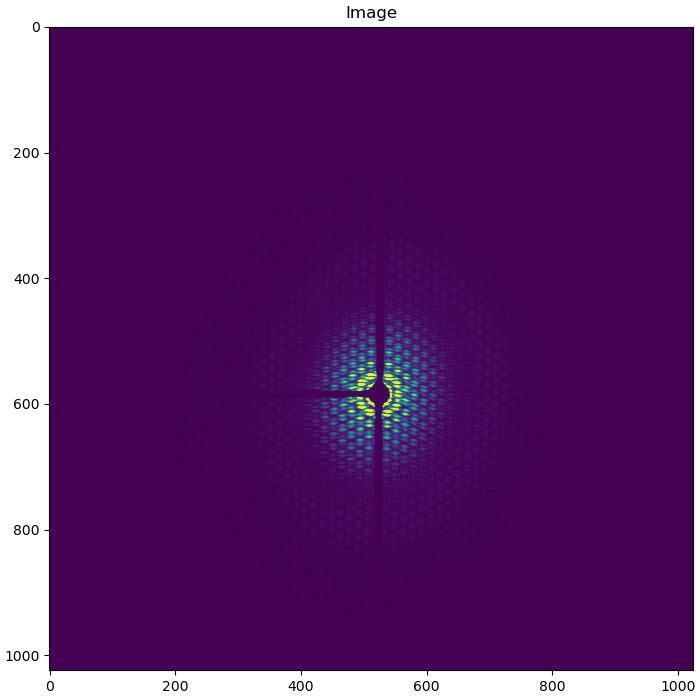

In [372]:
# Load image
image, _ = load_processing(im_id)

# Plot
fig, ax = cimshow(image)
ax.set_title("Image")

## Load topo data set and average

In [ ]:
# Load topo
(
    topo,
    _,
) = load_processing(topo_id)

# Plot
fig, ax = cimshow(topo)
ax.set_title("Topo")

## Load dark images

In [ ]:
# Load image
if dark_id is not None:
    ids = list_acquisition_filenames(dark_id, BASEFOLDER, acq_nrs=[], ONLY_CAMERA=True)
    dark, _ = load_processing_frames(
        ids, loadmode="avg", crop=crop_factor, nr_jobs=NR_JOBS
    )

    # Plot

    fig, ax = cimshow(dark)
    ax.set_title("Dark")
    
    # Subtract dark images
    image = image - dark
    topo = topo - dark

    # Show image
    fig, ax = cimshow(image)
    ax.set_title("Image with subtracted dark")

# Center holograms

* Find center of the hologram to get a well-defined q-space. 
* Create smooth mask for beamstop or overexposed areas in direct beam

## Basic widget to find center

Try to **align** the circles to the **center of the scattering pattern**. Care! Position of beamstop might be misleading and not represent the actual center of the hologram. 

In [ ]:
# Find center position via widget
c0, c1 = [586, 525]  # initial values
#c0, c1 = [1044, 1020]  # initial values
ic = interactive.InteractiveCenter(image, c0=c0, c1=c1)

In [ ]:
# Get center positions
center = [ic.c0, ic.c1]
print(f"Center:", center)

## Azimuthal integrator widget for finetuning
More of an "expert widget" which works very well for alignment if you have an Airy Pattern as a scattering image. PyFai transforms images from carthesian detector coordinate system into polar coordinate system with angle `phi` and radial distance `q` as axis (azimuthal transformation). The center of the coordinate system will be defined in the azimuthal integrator class and must not necessarily represents the center coordinates of your image array. If the center is set correctly, all rings of the Airy pattern will be transformed into a straight line in the I(q,chi)-plot as rings appear at a given q for all angles chi.

In [ ]:
# Setup azimuthal integrator for virtual geometry
ai = AzimuthalIntegrator(
    dist=experimental_setup["ccd_dist"],
    detector=detector,
    wavelength=experimental_setup["lambda"],
    poni1=center[0]
    * experimental_setup["px_size"]
    * experimental_setup["binning"],  # y (vertical)
    poni2=center[1]
    * experimental_setup["px_size"]
    * experimental_setup["binning"],  # x (horizontal)
)

In [ ]:
# Not the widget, just for double checking to find correct radial range for plotting
# Show some vertical lines at these qs
q_lines = [0.02, 0.04]

# Perform azimuthal transformation
I_t, q_t, phi_t = ai.integrate2d(
    image,
    500,  # number of points for phi
    radial_range=(0.01, 0.2),  # relevant q-range
    unit="q_nm^-1",
    correctSolidAngle=False,
)
# Combine in an xarray for plotting
az2d = xr.DataArray(I_t, dims=("phi", "q"), coords={"q": q_t, "phi": phi_t})

# Plot
fig, ax = plt.subplots()
mi, ma = np.percentile(I_t, [1, 95])
az2d.plot.imshow(ax=ax, vmin=mi, vmax=ma)
plt.title(f"Azimuthal integration")

# Add vertical lines to plot
for qt in q_lines:
    ax.axvline(qt, ymin=0, ymax=180, c="red")

In [ ]:
# The widget
aic = interactive.AzimuthalIntegrationCenter(
    np.log10(image),
    # image,
    ai,
    c0=center[0],
    c1=center[1],
    im_data_range=[1, 95],
    radial_range=(0.02, 0.15),
    circle_radius=40,
    qlines=[100, 110],
)

In [ ]:
# Get center positions from widget
center = [aic.c0, aic.c1]
print(f"Center:", center)

## Centering of image hologram

In [ ]:
# Apply to topo and image
shift_c = np.array(image.shape) / 2 - center
im_c = cci.shift_image(image, shift_c)
topo_c = cci.shift_image(topo, shift_c)  # centered image

# Image Registration

Relative drift between data holograms and their corresponding topo holograms is calculated by image registration algorithm. Necessary to get well-defined difference hologram. The reference is always the static background image (topo).

## Set Alignment ROI 

Set a region of interest (ROI) of reference (topo) use for image registration is performed. Don't select ROI which contains the beamstop as this leads to wrong results

How to use:
1. Zoom into the image and adjust your FOV until you are satisfied.
2. Save the axes coordinates.

In [ ]:
fig, ax = cimshow(im_c)
ax.set_title("Don't include the beamstop as this will misdirect the algorithm")

In [ ]:
# Takes start and end of x and y axis
x1, x2 = ax.get_xlim()
y2, y1 = ax.get_ylim()
roi_im_reg = np.array([y1, y2, x1, x2]).astype(int)

#roi_im_reg = [507, 945, 516, 955]  # other sample
#roi_im_reg = [275, 467, 272, 470]  # other sample
roi_im_reg = np.s_[roi_im_reg[0] : roi_im_reg[1], roi_im_reg[2] : roi_im_reg[3]]

print(f"Image registration roi:", roi_im_reg)

## Calculate drift of images

In [ ]:
shift = cci.image_registration(
    im_c[roi_im_reg],
    topo_c[roi_im_reg],
    method="dipy",
)
print(shift)

In [ ]:
# Optional: if drift is very small just set it to zero
shift = [0,0]

## Varify drift

In [ ]:
# Define shift manually for comparison
tmp_shift = [0.03, 20]

# Loop over shifts
temp_diff = np.zeros((3, im_c.shape[0], im_c.shape[1]))
shifts = [
    [0, 0],
    tmp_shift,
    -shift,
]
for i, tshift in enumerate(shifts):
    temp = cci.shift_image(im_c, tshift)
    temp_factor = cci.dyn_factor(temp, topo_c)
    temp_diff[i] = temp - temp_factor[0] * topo_c

# Plots for comparision
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12, 4))
mi, ma = np.percentile(temp_diff[0], [0.1, 99.9])
ax[0].imshow(temp_diff[0], vmin=mi, vmax=ma)
ax[0].set_title("Zero shift")
mi, ma = np.percentile(temp_diff[1], [0.1, 99.9])
ax[1].imshow(temp_diff[1], vmin=mi, vmax=ma)
ax[1].set_title("Manual shift: %s" % shifts[1])
mi, ma = np.percentile(temp_diff[2], [0.1, 99.9])
ax[2].imshow(temp_diff[2], vmin=mi, vmax=ma)
ax[2].set_title("Auto shift: %s" % np.round(shifts[2], 2))

## Center and apply circular beamstop to topo image

In [ ]:
# Shift and apply beamstop
topo_c = cci.shift_image(topo, shift_c + shift)  # centered image

# Plot original and shifted holos
mi, ma = np.percentile(np.real(im_c[im_c != 0]), (0.1, 99))
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12, 4))
ax[0].imshow(np.real(image), cmap="viridis", vmin=mi, vmax=ma)
ax[0].set_title("Uncentered image")
ax[1].imshow(np.real(im_c), cmap="viridis", vmin=mi, vmax=ma)
ax[1].set_title("Centered image")
mi, ma = np.percentile(im_c-topo_c,[.5,99.5])
ax[2].imshow(im_c-topo_c, cmap="viridis", vmin=mi, vmax=ma)
ax[2].set_title("im_c-topo_c")

# Add circles with different radi r
tmp = np.array(image.shape) / 2
for r in np.arange(50, 150, 25):
    ax[0].add_artist(plt.Circle((tmp[1], tmp[0]), r, fill=None, ec="red"))
    ax[1].add_artist(plt.Circle((tmp[1], tmp[0]), r, fill=None, ec="red"))
    ax[2].add_artist(plt.Circle((tmp[1], tmp[0]), r, fill=None, ec="red"))

# Create beamstops

We want to cover the beamstop with a smooth circle to cover its sharp edges as these would create ringing-like artifacts in the reconstruction plane. Make it only as large as necessary to keep as much information as possible.

## Circle beamstop

In [ ]:
# Set beamstop diameter and std for smoothing filter.
# Higher values mean stronger smoothing.
# If you have a very small beamstop you might need to reduce the smoothing value.
# Otherwise the beamstop center won't mask the direct beam with zeros
bs = interactive.InteractiveBeamstop(
    im_c, im_c.shape[0] / 2, im_c.shape[1] / 2, rBS=44, stdBS=3,
)

In [ ]:
# Take value from widget and create beamstop mask
bs_diam = bs.rBS
bs_smoothing = bs.stdBS
mask_bs = 1 - cci.circle_mask(
    topo.shape, np.array(topo.shape) / 2, bs.rBS, sigma=bs_smoothing
)

# Apply beamstop to image
im_b = im_c * mask_bs
topo_b = topo_c * mask_bs

# Plot image with beamstop and valid pixel mask
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(9, 3))
mi, ma = np.percentile(im_b, [0.1, 99.9])
ax[0].imshow(im_b, cmap="viridis", vmin=mi, vmax=ma)
ax[0].set_title("Masked image")

ax[1].imshow(mask_bs)
ax[1].set_title("Beamstop mask")

ax[2].imshow(1 - mask_bs)
ax[2].set_title("1 - Beamstop mask")

## Manual masking of beamstop wires

In [ ]:
poly_mask = interactive.draw_polygon_mask(np.log10(im_c))

In [ ]:
# Take poly coordinates and mask from widget
p_coord = poly_mask.get_vertice_coordinates()
mask_draw = poly_mask.full_mask.astype(int)

print("Copy these coordinates into the 'load_poly_coordinates()' function:")
print(p_coord)

# Plot image with beamstop and valid pixel mask
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(9, 3))
mi, ma = np.percentile(im_c * (1 - mask_draw), [0.1, 99.9])
ax[0].imshow(im_c * (1 - mask_draw), cmap="viridis", vmin=mi, vmax=ma)
ax[0].set_title("Image * (1-mask_draw)")

mi, ma = np.percentile(im_c * mask_draw, [0.1, 99.9])
ax[1].imshow(im_c * mask_draw, vmin=mi, vmax=ma)
ax[1].set_title("Image * mask_draw")

ax[2].imshow(1 - mask_draw)
ax[2].set_title("1 - mask_draw")

In [ ]:
def load_poly_coordinates():
    """
    Dictionary that stores polygon corner coordinates of all drawn masks
    Example: How to add masks with name "test":
    mask_coordinates["test"] = copy coordinates from above
    """

    # Setup dictonary
    mask_coordinates = dict()
    mask_coordinates["beamstop"] = [[(503.5, 490.0), (502.7, 493.8), (499.3, 497.1), (495.6, 499.5), (491.8, 502.9), (467.4, 503.4), (417.2, 504.0), (404.5, 501.8), (398.0, 503.9), (271.7, 505.7), (242.2, 506.1), (98.6, 507.2), (-3.3, 508.8), (-3.0, 523.1), (105.3, 523.0), (181.5, 522.1), (256.8, 520.9), (323.0, 519.9), (376.1, 519.1), (420.7, 518.4), (444.0, 519.6), (460.4, 518.4), (479.2, 517.3), (492.1, 518.0), (496.4, 522.8), (501.0, 526.9), (503.3, 530.5), (503.3, 541.7), (503.3, 611.0), (502.2, 709.8), (502.2, 799.6), (502.4, 908.5), (502.5, 1024.1), (517.4, 1024.5), (517.5, 907.9), (516.8, 800.8), (517.5, 703.8), (518.7, 624.4), (518.7, 590.9), (517.4, 542.6), (517.7, 535.1), (518.4, 530.9), (520.7, 528.3), (524.7, 523.7), (528.3, 520.6), (530.8, 514.3), (530.8, 507.6), (527.6, 501.3), (523.8, 495.2), (519.1, 491.2), (520.8, 475.7), (520.6, 400.4), (519.3, 290.6), (519.5, 194.2), (520.6, 107.7), (522.8, 3.9), (523.9, -2.1), (508.3, -3.0), (507.6, 49.3), (506.4, 152.7), (506.5, 261.0), (505.4, 358.4), (506.0, 452.0), (505.5, 474.0), (506.0, 483.0)]]
    mask_coordinates["bottom_stripe"] = [[(1025.2, 939.7), (-9.3, 939.2), (-6.8, 954.8), (530.0, 959.8), (1026.2, 961.7)]]
    return mask_coordinates

In [ ]:
# Which drawn masks do you want to load? You can combine multiple masks from
# load_poly_coordinates(). Just add names of mask as strings to list like
# ["bs_small","bs_medium"]
polygon_names = ["beamstop","bottom_stripe"]  # ["bs_test"]
mask_draw = mask_lib.load_poly_masks(
    im_c.shape,
    load_poly_coordinates(),
    polygon_names,
)

# Expand/shrink Mask if necessary
# footprint = skimage.morphology.disk(3)
# mask_draw = skimage.morphology.dilation(mask_draw, footprint) # increase size
# mask_draw = skimage.morphology.erosion(mask_draw, footprint) # decrease size

# The relative position of the drawn beamstop with respect to the actual beamstop
# might change due to sample change, sample drift, realignment, etc. The drawn
# beamstop mask would therefore not cover the actual beamstop position. This function
# aligns the beamstop mask with respect to the actual position
optimize_position = False

# Optimize position of drawn mask relative to target image
if optimize_position is True:
    # level 1 (rough)
    optimized_shift, mask_shifted, _ = mask_lib.auto_shift_mask(
        mask_draw,
        im_c,
        shift_range_y=[-10, 10],
        shift_range_x=[-10, 10],
        step_size=4,
        crop=300,
    )
    ## Level 2 (fine)
    optimized_shift, mask_shifted, overlap = mask_lib.auto_shift_mask(
        mask_draw,
        im_c,
        shift_range_y=[optimized_shift[0] - 4, optimized_shift[0] + 4],
        shift_range_x=[optimized_shift[1] - 4, optimized_shift[1] + 4],
        step_size=0.5,
        crop=300,
    )
    mask_draw = mask_shifted.copy()

# Shift mask
# mask_draw = np.round(cci.shift_image(mask_draw,[2,0]))

# Plot image with beamstop and valid pixel mask
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(9, 3))
mi, ma = np.percentile(im_c * (1 - mask_draw), [0.1, 99])
ax[0].imshow(im_c * (1 - mask_draw), cmap="viridis", vmin=mi, vmax=ma)
ax[0].set_title("Image * (1-mask_draw)")

# mi, ma = np.percentile(im_c * mask_draw, [0.1, 90])
ax[1].imshow(im_c * mask_draw, vmin=mi, vmax=ma)
ax[1].set_title("Image * mask_draw")

ax[2].imshow(1 - mask_draw)
ax[2].set_title("1 - mask_draw")

## Finetuning of mask position

In [ ]:
# Use widget to shift and expand or shrink the mask
ss_mask = interactive.Shift_Scale_Mask(im_c, mask_draw, shift=[0, 0], scale=0)

In [ ]:
# Take mask, shift and scaling from widget
mask_draw, mask_shift, mask_scale = ss_mask.get_mask()

In [ ]:
# Add circular beamstop mask
mask_im = mask_draw.copy()
mask_topo = mask_im.copy()

# Mask over-saturated pixel
mask_im = mask_im + (im_c > experimental_setup["int_cutoff"])
mask_topo = mask_topo + (topo_c > experimental_setup["int_cutoff"])

# Combine both
mask_pixel = mask_im + mask_topo

# Add beamstop
# mask_pixel = mask_pixel + (mask_bs <= 0.5)
mask_pixel[mask_pixel > 1] = 1

# Create smooth mask for FTH reconstructions
footprint = skimage.morphology.disk(6)
mask_pixel_smooth = skimage.morphology.dilation(mask_pixel, footprint)
mask_pixel_smooth = gaussian_filter(mask_pixel_smooth, 2)

# Plot both
fig, ax = plt.subplots(2, 4, figsize=(10, 5), sharex=True, sharey=True)
mi, ma = np.percentile(im_c, [1, 99.9])
ax[0, 0].imshow(im_c, vmin=mi, vmax=ma)
ax[0, 0].set_title("Image")
mi, ma = np.percentile(im_c * mask_im, [1, 99.99])
ax[0, 1].imshow(im_c * mask_im, vmin=mi, vmax=ma)
ax[0, 1].set_title("Image*mask")
mi, ma = np.percentile(im_c * (1 - mask_im), [0.1, 99.9])
ax[0, 2].imshow(im_c * (1 - mask_im), vmin=mi, vmax=ma)
ax[0, 2].set_title("Image*(1-mask)")
ax[0, 3].imshow(mask_pixel_smooth)
ax[0, 3].set_title("Combined Mask")

mi, ma = np.percentile(topo_c, [1, 99.9])
ax[1, 0].imshow(topo_c, vmin=mi, vmax=ma)
ax[1, 0].set_title("Topo")
mi, ma = np.percentile(topo_c * mask_im, [1, 99.99])
ax[1, 1].imshow(topo_c * mask_topo, vmin=mi, vmax=ma)
ax[1, 1].set_title("Topo*mask")
mi, ma = np.percentile(topo_c * (1 - mask_topo), [0.1, 99.9])
ax[1, 2].imshow(topo_c * (1 - mask_topo), vmin=mi, vmax=ma)
ax[1, 2].set_title("topo*(1-mask)")
mi, ma = np.percentile((im_c - topo_c) * (1 - mask_pixel_smooth), [0.1, 99.9])
ax[1, 3].imshow((im_c - topo_c) * (1 - mask_pixel_smooth), vmin=mi, vmax=ma)
ax[1, 3].set_title("Image-Topo")

# Calculate difference holograms

You can see the reconstrution of the magnetization only after subtracting the large background that you get from the diffraction on the circular object aperture (Airy Pattern). This might require a scaling factor to correct intensity changes between the hologram and the topo. Scaling factor will be determined automatically by a linear fit. If the fit seems off, there might be an issue with the data

In [ ]:
# Get scaling factor and offset
factor, offset = cci.dyn_factor(
    im_c * (mask_bs) * (1 - mask_pixel),
    topo_c * (mask_bs) * (1 - mask_pixel),
    method="correlation",
    print_out=True,
    plot=True,
    crop=0,
)

# Calculate differences (magnetic) and sums (topographc) contrast holograms.
# _c: centered, without beamstop, _b: centered, with beamstop
diff_c = im_c / factor - topo_c - offset
diff_b = diff_c * mask_bs
sum_c = im_c / factor + topo_c - offset
sum_b = sum_c * mask_bs

In [ ]:
# Plot an example of the difference or sum hologram
fig, ax = cimshow(diff_c * (1 - mask_pixel_smooth))
ax.set_title(f" Diff Id %s - %s" % (im_id, topo_id))

# fig, ax = cimshow(sum_b)
# ax.set_title(f" Sum Id %d" % im_id)

# Reconstruct Diff Holos (FTH)

Reconstruct the hologramm.
1. Chose a region of interest (ROI) which means selecting one reconstruction from the rconstruction plane.
2. Propagate the image and shift the phase for maximal contrast and sharpness in your ROI
3. Optional finetuning with a widget

## Set Patterson Map ROI

Choose the reconstructions as the ROI.

1. Zoom into the image and adjust your FOV until you are satisfied.
2. Save the axes coordinates.

In [ ]:
# Choose contrast mode
# diff_c: magnetic contrast only
# sum_c: topographic contrast only

holo = diff_c * mask_bs * (1 - mask_pixel_smooth)
holo = sum_c * mask_bs * (1 - mask_pixel_smooth)
# holo = im_c * mask_bs * (1 - mask_pixel_smooth)
# holo = topo_c * mask_bs * (1 - mask_pixel_smooth)

fig, ax = cimshow(np.real(fth.reconstruct(holo)), cmap="gray")

In [ ]:
# Execute to get roi
x1, x2 = ax.get_xlim()
y2, y1 = ax.get_ylim()
roi = np.array([y1, y2, x1, x2]).astype(int)  # ystart, ystop, xstart, xstop
roi = [276, 408, 439,599]
roi_s = np.s_[roi[0] : roi[1], roi[2] : roi[3]]
print(f"Roi Reco:{roi}")

## Tune propagation and phase
Focus the image by tuning the propagation distance. This really works like focussing in a microscope.
Phase slider will move contrast between real and imaginary part. Usually we use the phase which maximizes the contrast in the real part

In [ ]:
# Widget
slider_prop, slider_phase, button = reco.propagate(
    diff_b * (1 - mask_pixel_smooth),
    roi_s,
    phase=0,
    prop_dist=0,
    experimental_setup=experimental_setup,
    scale=(1, 99),
)

In [ ]:
# Read prop dist and phase from widget
prop_dist = slider_prop.value
phase = slider_phase.value

print(f"Propagation distance: %0.2f" % prop_dist)
print(f"Phase: %0.2f" % phase)

## Save reconstruction

Save png files of the images and a h5 file for all important variables

In [ ]:
def plot_recon(recon, title):
    # Plot
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    fig.suptitle(title)

    vmin, vmax = np.percentile(np.real(recon), (1, 99))
    t_im1 = ax[0].imshow(np.real(recon), vmin=vmin, vmax=vmax, cmap="gray")
    ax[0].set_title("Real")
    plt.colorbar(t_im1, ax=ax[0], aspect=50)

    vmin, vmax = np.percentile(np.imag(recon), (1, 99))
    t_im2 = ax[1].imshow(np.imag(recon), vmin=vmin, vmax=vmax, cmap="gray")
    ax[1].set_title("Imag")
    plt.colorbar(t_im2, ax=ax[1], aspect=50)

In [ ]:
def get_title(data_key, im_id,topo_id, CDI=False):
    # Add "cdi" to title
    if CDI is True:
        suffix = "CDI"
    elif CDI is False:
        suffix = ""

    # Get file and data
    fname = loading.generate_filename(raw_folder, sample_name, ".nxs", im_id)
    print(fname)
    data = loading.load_data(fname, mnemonics["data"], keys = data_key)

    #Create title of reconstruction figure
    if data_key == "magnett_read":
        values = np.mean(np.array(data[data_key]) * 1000)
        values = np.round(values, 2)
        title = "Image %d - %s @%.2f mT %s" % (im_id, topo_id, values,suffix)
    else: 
        title = "Image %d - %d %s" % (im_id, topo_id,suffix)

    return title

In [ ]:
# Saves only real and imaginary part
holo = diff_b * (1 - mask_pixel_smooth)
#holo = diff_b.copy()# * (1 - mask_pixel_smooth)
recon = np.zeros(image.shape, dtype=np.complex_)

# Reconstruct
recon = fth.reconstruct(
    fth.propagate(holo, prop_dist * 1e-6, experimental_setup=experimental_setup)
    * np.exp(1j * phase)
)

# Create plot
plot_recon(recon[roi_s], get_title("magnett_read",im_id,topo_id,CDI = False))

# Save images
fname = join(
    folder_general,
    "Recon_ImId_%04d_RefId_%04d_%s.png" % (im_id, topo_id, USER),
)
print("Saving: %s" % fname)
plt.savefig(fname, bbox_inches="tight", transparent=False)

# Save hdf5 file
save_fth_h5()

In [ ]:
# Closes all existing plots
plt.close("all")

# CDI Reconstruction

## Create set of pos and neg helicity holograms

In [ ]:
# Copy values from FTH reco
pos = (im_c / factor).copy()
neg = (topo_c).copy()

#pos = (sum_c + diff_c) / 2
#neg = (sum_c - diff_c) / 2

## Create hologram mask for phase retrieval
``mask_pixel[px,px] == 1`` means invalid, i.e., will be replaced by phase retrieval

In [ ]:
# Use widget to shift and expand or shrink the mask
ss_mask = interactive.Shift_Scale_Mask(pos, mask_pixel, shift=[0, 0], scale=0)

In [ ]:
cimshow(np.log10(pos))

In [ ]:
# Take mask, shift and scaling from widget
mask_pixel_cdi, mask_shift, mask_scale = ss_mask.get_mask()

## Create Support mask

The support mask is the real-space constraint used for the (holographically-aided) phase retrieval, i.e., certain details about our sample like the sample geometry. For our samples we can directly derive a very strong constraint: The FTH reconstructions show us previsely the actual real-space sample structure, i.e., the arrangement of our aperture where x-rays are transmitted ("1") while the masked areas show no transmission ("0"). We will therefore create a binary mask that reflects this transmission as an input for the phase retrieval.

How to draw a support mask: Create a binary mask of the locations of sample apertures in the fth reconstruction. Areas with apertures are "1". Select only a single set of reconstructions (object & reference apertures) that originate from a single reference. Use the widget!

## Execute if you want to create a new support mask

In [ ]:
# How many references do you have?
nr_ref = 6

# Setup coordinates (nr_ref + 1 coordinates, as there is always the object aperture)
support_coordinates = [
    [pos.shape[-2] // 2, pos.shape[-1] // 2, 7] for k in range(nr_ref + 1)
]

# Widget to find the positions and sizes of the different apertures
print(
    "Cover the object & reference apertures for each set of reconstructions that originates from the same reference with circles."
)
print(
    "Optimization: Change one circle parameter, calc phase retrieval image, compare with images reconstructed with old circle parameter. Repeat!"
)

# Create plot
holo = pos * mask_bs * (1 - mask_pixel_smooth)

# Reconstruct
recon = fth.reconstruct(
    fth.propagate(holo, prop_dist * 1e-6, experimental_setup=experimental_setup)
    * np.exp(1j * phase)
)
recon = np.real(recon)

ds = interactive.InteractiveCircleCoordinates(
    recon,
    len(support_coordinates),
    coordinates=support_coordinates.copy(),
)

In [ ]:
# Take coordinates of circles from widget
support_coordinates = ds.get_params()

# Create supportmask from coordinates
supportmask = mask_lib.create_circle_supportmask(support_coordinates, pos.shape)

# Plot supportmask as overlay
fig, ax = plt.subplots(figsize=(6, 6))
mi, ma = np.percentile(recon, (1, 99))
ax.imshow(recon, vmin=mi, vmax=ma, cmap="gray")
ax.imshow(supportmask, alpha=0.8, cmap="binary")
ax.set_title("Image with overlayed mask")
print(support_coordinates)

## Option 2: Execute if you want to load an existing support mask

In [ ]:
def get_supportmask_coordinates(sample):
    """
    Dictionary that stores coordinates of circular support mask apertures
    """

    # Setup dictonary
    support_coord = dict()

    # coordinates
    support_coord["MFA_e43b_binned"] = [(227.0, 380.5, 28.5), (83.5, 352.5, 7.0), (30.5, 389.5, 6.0), (85.5, 424.0, 5.0), (505.5, 243.0, 7.0), (536.0, 377.0, 6.5), (512.0, 512.0, 6.0)]

    return support_coord[sample]

In [ ]:
# Which supportmask to load? ("s2306a-C1", "s2308a-B1", ...)
sample = "MFA_e43b_binned"

# Get coordinates and create supportmask
support_coordinates = get_supportmask_coordinates(sample)

In [ ]:
# Widget to find the positions and sizes of the different apertures
print(
    "Cover the object & reference apertures for each set of reconstructions that originates from the same reference with circles."
)
print(
    "Optimization: Change one circle parameter, calc phase retrieval image, compare with images reconstructed with old circle parameter. Repeat!"
)

# Plotting image
holo = pos.copy() * mask_bs * (1 - mask_pixel_smooth)

# Reconstruct
recon = fth.reconstruct(
    fth.propagate(holo, prop_dist * 1e-6, experimental_setup=experimental_setup)
    * np.exp(1j * phase)
)
recon = np.real(recon)

ds = interactive.InteractiveCircleCoordinates(
    recon,
    len(support_coordinates),
    coordinates=support_coordinates,
)

In [ ]:
# Take coordinates of circles from widget
support_coordinates = ds.get_params()

# Create supportmask from coordinates
supportmask = mask_lib.create_circle_supportmask(support_coordinates, pos.shape)

# Plot supportmask as overlay
fig, ax = plt.subplots(figsize=(6, 6))
mi, ma = np.percentile(recon, (1, 99))
ax.imshow(recon, vmin=mi, vmax=ma, cmap="gray")
ax.imshow(supportmask, alpha=0.4, cmap="binary")
ax.set_title("Image with overlayed mask")
print(support_coordinates)

### Take Roi

In [ ]:
fig, ax = cimshow(supportmask.astype(int))

In [ ]:
roi_cdi = interactive.axis_to_roi(ax)
#roi_cdi = [11,563,172,561] #
roi_cdi = [185,266,340,416] #
roi_cdi = np.s_[roi_cdi[0] : roi_cdi[1], roi_cdi[2] : roi_cdi[3]]
print("Sliced roi:", roi_cdi)

## Do Phase Retrieval

In [ ]:
# Lower boundary for subtraction of background [0,100]
offset_vmin = 1

# Options for initial guess
recon = fth.reconstruct(
    fth.propagate(pos, prop_dist * 1e-6, experimental_setup=experimental_setup)
    * np.exp(1j * phase)
)
Startimage = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(recon * supportmask)))
Startimage = None
Startgamma = None

# Executes algorithm
(
    retrieved_n,
    retrieved_p,
    retrieved_n_pc,
    retrieved_p_pc,
    bsmask_n,
    bsmask_p,
    gamma_n,
    gamma_p,
) = phase_retrieval(
    neg,
    pos,
    mask_pixel_cdi.astype(int),
    supportmask,
    vmin=offset_vmin,
    Startimage=Startimage,
    Startgamma=Startgamma,
)

## Reconstruct images

In [ ]:
# New beamstop for CDI recos as phase retrieval of low-q might be insufficient. If phase retrieval worked well
# Try without beamstop: `use_bs = False`
use_bs = False
bs_diam_cdi = 30  # diameter of beamstop

# Create beamstop
if use_bs is True:
    mask_bs_cdi = 1 - mask_lib.circle_mask(
        pos.shape, np.array(pos.shape) / 2, bs_diam_cdi, sigma=4
    )
    mask_bs_cdi = 1 - mask_pixel_smooth.copy()
elif use_bs is False:
    mask_bs_cdi = np.ones(pos.shape)  # if you don't want a beamstop

# Get Recos partial coherence
# Positiv partial coherence
p_pc = cci.reconstruct(
    fth.propagate(
        retrieved_p_pc * mask_bs_cdi,
        prop_dist_cdi * 1e-6,
        experimental_setup=experimental_setup,
    )
)

# Negative partial coherence
n_pc = cci.reconstruct(
    fth.propagate(
        retrieved_n_pc * mask_bs_cdi,
        prop_dist_cdi * 1e-6,
        experimental_setup=experimental_setup,
    )
)

# optimize phase
recon = p_pc - n_pc
# _, phase_cdi = optimize_phase_contrast(
#    recon, supportmask, method="contrast", prefered_color="white"
# )

# Plotting
mode = "-"
slider_prop, slider_phase, slider_dx, slider_dy = rec.focusCDI(
    retrieved_p_pc * mask_bs_cdi,
    retrieved_n_pc * mask_bs_cdi,
    roi_cdi,
    # mask=supportmask,
    phase=phase_cdi,
    dx=dx,
    dy=dy,
    prop_dist=prop_dist_cdi,
    experimental_setup=experimental_setup,
    operation=mode,
    max_prop_dist=5,
    scale=(0.1, 99.9),
)
print("Fine-tuning of reconstruction parameter:")

In [ ]:
# Get phase from slider
phase_cdi = slider_phase.value
prop_dist_cdi = slider_prop.value

# Reconstruct images with new parameter
p_pc = fth.reconstructCDI(
    fth.propagate(
        retrieved_p_pc * mask_bs_cdi,
        prop_dist_cdi * 1e-6,
        experimental_setup=experimental_setup,
    )
) * np.exp(1j * phase_cdi)

n_pc = fth.reconstructCDI(
    fth.propagate(
        retrieved_n_pc * mask_bs_cdi,
        prop_dist_cdi * 1e-6,
        experimental_setup=experimental_setup,
    )
) * np.exp(1j * phase_cdi)


print("Phase CDI: %s" % phase_cdi)
print("Prop_dist: %s" % prop_dist_cdi)

In [ ]:
# Confirm that offset subtraction in cdi function works, i.e., only small fraction of hologram is actually masked
fig, ax = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)
tmp = np.abs(retrieved_p_pc * mask_bs_cdi)
mi, ma = np.percentile(tmp, [0.1, 99.9])
ax[0, 0].imshow(tmp, vmin=mi, vmax=ma)
ax[0, 0].set_title("Pos holo")

tmp = np.abs(retrieved_n_pc)
mi, ma = np.percentile(tmp, [0.1, 99.9])
ax[0, 1].imshow(tmp, vmin=mi, vmax=ma)
ax[0, 1].set_title("Neg holo")
ax[1, 0].imshow(bsmask_p)
ax[1, 0].set_title("Pos holo mask")
ax[1, 1].imshow(bsmask_n)
ax[1, 1].set_title("Neg holo mask")

In [ ]:
cimshow(np.real(p_pc))

## Save

In [ ]:
def plot_recon(recon, title):
    # Plot
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    fig.suptitle(title)

    vmin, vmax = np.percentile(np.real(recon), (.1, 99.9))
    t_im1 = ax[0].imshow(np.real(recon), vmin=vmin, vmax=vmax, cmap="gray")
    ax[0].set_title("Real")
    plt.colorbar(t_im1, ax=ax[0], aspect=50)

    vmin, vmax = np.percentile(np.imag(recon), (.1, 99.9))
    t_im2 = ax[1].imshow(np.imag(recon), vmin=vmin, vmax=vmax, cmap="gray")
    ax[1].set_title("Imag")
    plt.colorbar(t_im2, ax=ax[1], aspect=50)

In [ ]:
# Saves only real and imaginary part
recon_all = p_pc - n_pc  # / (p_pc + n_pc)
recon = recon_all.copy()

# Plot
plot_recon(recon[roi_cdi], get_title("magnett_read",im_id,topo_id,CDI = True))

# Save images
fname = join(
    folder_general,
    "Recon_ImId_%04d_RefId_%s_cdi_%s.png" % (im_id, topo_id, USER),
)
print("Saving: %s" % fname)
plt.savefig(fname, bbox_inches="tight", transparent=False)

# Save h5
save_cdi_h5()

# Batch processing CDI

## Define Scan Ids

In [ ]:
# Load support mask of which sample?
sample = "s2305e-C5_binned"

In [ ]:
# Define the sets for reconstructions. You can make a list or use np.arange
# im_id_set should always have ids of positive helicity holograms,
# topo_id_set those of negative helicity or a proper topo

im_id_set = np.arange(384, 385 + 1)
topo_id_set = 383 * np.ones(len(im_id_set), dtype=int)

# In case of single helicity reconstructions, adapt the helicity
# for contrast inversion
helicity = 1 * np.ones(len(im_id_set), dtype=int)  # [1,-1]

# Do cdi?
do_cdi = True

# Save fth reco?
save_fth = True

print("Dynamics Set:  %s" % im_id_set)
print("Reference Set: %s" % topo_id_set)
print("Helicity: %s" % helicity)

## Execute Stack Reconstruction

In [ ]:
# Ugly Automatic processing of image stacks
recons_name = []  # for gifs
for it, im_id in enumerate(im_id_set):
    # Load images
    image, _ = load_processing(im_id)

    # Get topo
    # Do you want to construct topo holo from two helicity images
    try:
        len(topo_id_set[it])
    except:
        # Usual case
        # Get also topo & dark id from list of sets
        topo_id = topo_id_set[it]

        # Load data
        print(f"Loading imageId: %04d, topoId: %04d" % (im_id, topo_id))
        topo, _ = load_processing(topo_id)

        # Process images
        worker_dict = worker(image, topo)

        # Save topo hologram
        save_topo_holo(worker_dict["sum_c"], im_id, topo_id)
    else:
        print("Using Topo from sum of two helicity holograms")
        pos_id = topo_id_set[it][0]
        neg_id = topo_id_set[it][1]
        topo_id = topo_id_set[it]

        try:
            topo = load_topo_holo(pos_id, neg_id) / 2
        except:
            topo = load_topo_holo(neg_id, pos_id) / 2
        topo = cci.shift_image(
            topo, -shift_c
        )  # shift out of center so you don't need to change the worker

        # Process images
        worker_dict = worker(image, topo)

    # Reconstruct
    recon = fth.reconstruct(
        fth.propagate(
            worker_dict["holo"], prop_dist * 1e-6, experimental_setup=experimental_setup
        )
        * np.exp(1j * phase)
    )

    # Plot
    plot_recon(recon[roi_cdi], get_title(im_id,topo_id))

    # Save images
    if save_fth is True:
        fname = join(
            folder_general,
            "Recon_ImId_%04d_RefId_%s_fth_diff_stack_%s.png" % (im_id, topo_id, USER),
        )
        print("Saving: %s" % fname)
        plt.savefig(fname, bbox_inches="tight", transparent=False)

    ################ CDI ###############
    if do_cdi is True:
        # Create pos and neg helicity set
        pos = (worker_dict["sum_c"] + worker_dict["diff_c"]) / 2
        neg = (worker_dict["sum_c"] - worker_dict["diff_c"]) / 2

        # Create beamstop automatically
        mask_im, mask_topo, mask_pixel, mask_pixel_smooth = create_auto_beamstop(
            pos, neg, mask_draw, use_bs, bs_param
        )

        fig, ax = cimshow(pos*(1-mask_pixel.astype(int)))
        ax.set_title("Verify that this looks like an acceptable beamstop")

        # Get coordinates and create supportmask
        support_coordinates = get_supportmask_coordinates(sample)
        supportmask = create_supportmask(support_coordinates, pos.shape)

        # Do phase retrieval
        (
            retrieved_p,
            retrieved_n,
            retrieved_p_pc,
            retrieved_n_pc,
            bsmask_p,
            bsmask_n,
            gamma_p,
            gamma_n,
        ) = phase_retrieval(
            pos, neg, mask_pixel, supportmask, Startimage=None, Startgamma=None
        )

        # Get Recos partial coherence
        # Positiv partial coherence
        p_pc = fth.reconstructCDI(
            fth.propagate(
                retrieved_p_pc * mask_bs_cdi,
                prop_dist_cdi * 1e-6,
                experimental_setup=experimental_setup,
            )
        )
        # Negative partial coherence
        n_pc = fth.reconstructCDI(
            fth.propagate(
                retrieved_n_pc * mask_bs_cdi,
                prop_dist_cdi * 1e-6,
                experimental_setup=experimental_setup,
            )
        )

        ##### Calc reco and optimze contrast
        recon = helicity[it] * (p_pc - n_pc)
        _, phase_cdi = optimize_phase_contrast(
            recon,
            supportmask,
            method="contrast",
            prefered_color="white",
        )
        # phase_cdi = 0
        recon = recon * np.exp(1j * phase_cdi)
        print("Phase is:", np.round(phase_cdi, 2))
        ########

        # Plot
        plot_recon(recon[roi_cdi], get_title(im_id,topo_id))

        # Save images
        fname = join(
            folder_general,
            "Recon_ImId_%04d_RefId_%s_cdi_stack_%s.png" % (im_id, topo_id, USER),
        )

        print("Saving: %s" % fname)
        plt.savefig(fname, bbox_inches="tight", transparent=False)
        recons_name.append(fname)

        # Save files as h5
        save_cdi_h5()
    else:
        print("Phase retrieval disabled!")

    print(" ")
print("CDI stack processing finished")

In [ ]:
plt.close("all")